## Setup

In [ ]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ua65q0_y
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ua65q0_y


In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## Load the CIFAR 10 dataset



In [ ]:
(train_images, train_y), (test_images, test_y) = tf.keras.datasets.cifar10.load_data()

In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
  return images.astype('float32')
  #return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


In [ ]:
train_size = np.shape(train_images)[0]
batch_size = 32
test_size = 60000

## Use *tf.data* to batch and shuffle the data

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

Première version : simple et efficace

Seconde version : plus compliqué

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim,size):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.size = size
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
         
            tf.keras.layers.Conv2D(
                filters=size/4, kernel_size=3, strides=(1, 1), activation='relu'),
            tf.keras.layers.BatchNormalization(),
           # tf.keras.layers.Conv2D(
           #    filters=size/4, kernel_size=3, strides=(1, 1), activation='relu'),
           # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size/4, kernel_size=3, strides=(2, 2), activation='relu'),
            
            tf.keras.layers.Conv2D(
                filters=size/2, kernel_size=3, strides=(1, 1), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size/2, kernel_size=3, strides=(1, 1), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size/2, kernel_size=3, strides=(2, 2), activation='relu'),

            tf.keras.layers.Conv2D(
                filters=size, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size, kernel_size=3, strides=(1, 1), activation='relu'),

            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*128*3, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 128*3)),
         
            tf.keras.layers.Conv2DTranspose(
                filters=size, kernel_size=3, strides=1, padding='same',
                activation='relu',data_format="channels_last"),
            tf.keras.layers.Conv2D(
                filters=size, kernel_size=3, strides=(1, 1), activation='relu',padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size, kernel_size=3, strides=(1, 1), activation='relu',padding='same'),
            tf.keras.layers.BatchNormalization(),
         
            tf.keras.layers.Conv2DTranspose(
                filters=size/2, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2D(
                filters=size/2, kernel_size=3, strides=(1, 1), activation='relu',padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size/2, kernel_size=3, strides=(1, 1), activation='relu',padding='same'),
            tf.keras.layers.BatchNormalization(),
         
            
            tf.keras.layers.Conv2DTranspose(
                filters=size/4, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            #tf.keras.layers.Conv2D(
            #    filters=size/4, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=size/4, kernel_size=3, strides=(1, 1), padding='same', activation='sigmoid'),
            tf.keras.layers.BatchNormalization(),
         
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape(target_shape=(32, 32, 3))
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:

class CVAE(tf.keras.Model):
  "Convolutional variational autoencoder."

  def __init__(self, latent_dim,size):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.size = size
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
         

            tf.keras.layers.Conv2D(
                filters=size/4, kernel_size=3, strides=(1, 1), activation='relu'),
            
            tf.keras.layers.Conv2D(
                filters=size/2, kernel_size=5, strides=(2, 2), activation='relu'),

            tf.keras.layers.Conv2D(
                filters=size, kernel_size=4, strides=(1, 1), activation='relu'),

            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16*16*size*3, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, size*3)),
         
            tf.keras.layers.Conv2DTranspose(
                filters=size, kernel_size=3, strides=1, padding='same',
                activation='relu',data_format="channels_last"),
         
            tf.keras.layers.Conv2DTranspose(
                filters=size/2, kernel_size=5, strides=2, padding='same',
                activation='relu'),
         
            
            tf.keras.layers.Conv2DTranspose(
                filters=size/4, kernel_size=4, strides=1, padding='same',
                activation='relu'),

            tf.keras.layers.Conv2D(
                filters=size, kernel_size=4, strides=(1, 1), activation='relu', padding='same'),

            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape(target_shape=(32, 32, 3))
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

NameError: ignored

## Define the loss function and the optimizer



In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 15
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 200
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim,256)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  print(np.shape(predictions))
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(8, 4, 2*i + 1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')
    plt.subplot(8, 4, 2*i + 2)
    plt.imshow(test_sample[i, :, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 15, Test set ELBO: 1749.848388671875, time elapse for current epoch: 205.98206281661987
(16, 32, 32, 3)


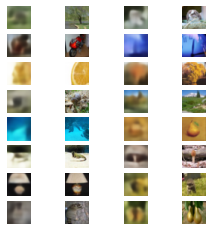

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

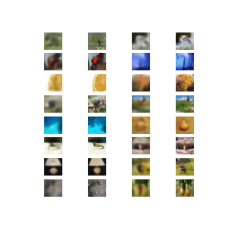

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


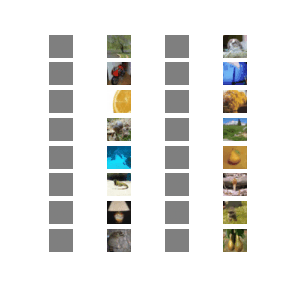

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display the transition between 2 images


im1 : 8045 im2 381


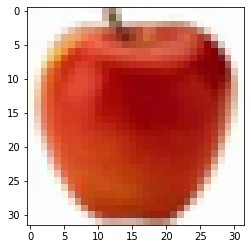

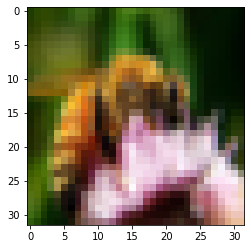

(1, 100)


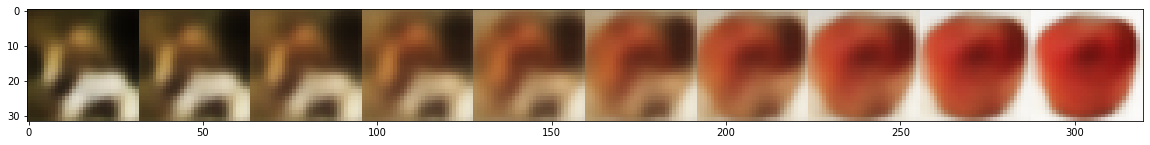

In [ ]:
from random import randint
def plot_transition(model, im1, im2,  n=15 ):
  digit_size = 32
  im1_latent_m,im1_latent_l = model.encode(np.array([im1]))
  z1 = model.reparameterize(im1_latent_m, im1_latent_l).numpy()
  im2_latent_m,im2_latent_l = model.encode(np.array([im2]))
  z2 = model.reparameterize(im2_latent_m, im2_latent_l).numpy()
  print(np.shape(z1))
  image_vector = np.zeros((digit_size, digit_size * n,3))
  for i in range(n):
    t = i / n
    #print("z1 = ",z1)
    z_sample = (t) * z1 + (1-t) * z2
    x_decoded = model.sample(z_sample)
    digit = tf.reshape(x_decoded[0], (digit_size, digit_size,3))
    image_vector[
                0 : digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = digit
  plt.figure(figsize=(20, 10))
  plt.imshow(image_vector, cmap="Greys_r")

#print(test_images[0].reshape((28, 28)))
#0 = chaussure 1 = manche longue 15 = pantalon 8 = tongue 9 = basquet 13 = robe
a = value = randint(0, 10000)
b = value = randint(0, 10000)
print("im1 :",a,"im2",b)
im1 =  test_images[a]
im2 = test_images[b] 
plt.imshow( im1.reshape((32, 32,3)), cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow( im2.reshape((32, 32,3)), cmap=plt.get_cmap('gray'))
plt.show()
plot_transition(model, im1,im2,n=10)

### Display a 2D manifold of digits from the latent space


In [ ]:

def plot_latent_space(model, n=10, figsize=10):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 3.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]


    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1,latent_dim))
            z_sample[0][0] = xi
            z_sample[0][1] = yi
            #print(np.shape(z_sample))
            x_decoded = model.sample(z_sample)
            #digit = x_decoded[0].reshape(digit_size, digit_size) 
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

InvalidArgumentError: ignored

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = vae.encode(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig("singe.png")
    plt.show()
    


#(x_train, ytrain)  = tf.keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(model, train_images, train_y)
